# Classifying fruits and vegetables using CNNs

In [16]:
import os
import torch
import torchvision
import tarfile
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch import nn
import torch.nn.functional as F

In [17]:
project_name='fruits-360-cnn'

# Exploring the data

We will be using the fruits 360 dataset from kaggle containing images of 131 different fruits and vegetables.You can find it <a href="https://www.kaggle.com/moltean/fruits">here</a>
<br>
First let us check out the dataset

In [18]:
data_dir = './fruits-360'

print(os.listdir(data_dir)) #folders in the dataset folder
classes = os.listdir(data_dir + "/Training")
#print first 10 classes
print(classes[:10])

['.DS_Store', 'LICENSE', 'Test', 'papers', 'Training', 'readme.md', 'test-multiple_fruits']
['Tomato 4', 'Apple Red Delicious', 'Tomato 3', 'Huckleberry', 'Blueberry', 'Pear Red', 'Banana Lady Finger', 'Melon Piel de Sapo', 'Pear', 'Cherry 1']


Let's look inside a couple of folders, one from the training set and another from the test set

In [19]:
pineapple_files = os.listdir(data_dir + "/Training/Pineapple")
print('No. of training images for pineapples:', len(pineapple_files))
print(pineapple_files[:5])

No. of training images for pineapples: 490
['r_236_100.jpg', '247_100.jpg', '257_100.jpg', 'r_78_100.jpg', 'r_68_100.jpg']


In [20]:
fig_test_files = os.listdir(data_dir + "/Test/Fig")
print('No. of test images for figs:', len(fig_test_files))
print(fig_test_files[:5])

No. of test images for figs: 234
['r_226_100.jpg', '198_100.jpg', '188_100.jpg', 'r2_117_100.jpg', 'r2_107_100.jpg']


Let us now see how many images are there for each class in the training data set

In [21]:
#create a dictionary to hold the count
train_image_count = {}
for item in classes:
    train_image_count[item] = 0
len(train_image_count)

131

In [22]:
#now let us find the count
for item in classes:
    train_image_count[item] = len( os.listdir(data_dir + "/Training/"+item))
    #print(train_image_count[item])

In [23]:
train_image_count

{'Tomato 4': 479,
 'Apple Red Delicious': 490,
 'Tomato 3': 738,
 'Huckleberry': 490,
 'Blueberry': 462,
 'Pear Red': 666,
 'Banana Lady Finger': 450,
 'Melon Piel de Sapo': 738,
 'Pear': 492,
 'Cherry 1': 492,
 'Strawberry': 492,
 'Nut Forest': 654,
 'Avocado': 427,
 'Tomato 2': 672,
 'Pomegranate': 492,
 'Dates': 490,
 'Carambula': 490,
 'Potato Red Washed': 453,
 'Granadilla': 490,
 'Kohlrabi': 471,
 'Tamarillo': 490,
 'Pepper Red': 666,
 'Fig': 702,
 'Ginger Root': 297,
 'Kiwi': 466,
 'Cherry Wax Yellow': 492,
 'Lemon': 492,
 'Guava': 490,
 'Apple Golden 2': 492,
 'Pear Stone': 711,
 'Apple Red 1': 492,
 'Cauliflower': 702,
 'Mandarine': 490,
 'Quince': 490,
 'Strawberry Wedge': 738,
 'Pear Monster': 490,
 'Raspberry': 490,
 'Pitahaya Red': 490,
 'Nut Pecan': 534,
 'Apple Golden 3': 481,
 'Redcurrant': 492,
 'Apple Red Yellow 1': 492,
 'Pepper Yellow': 666,
 'Grape Pink': 492,
 'Banana Red': 490,
 'Cucumber Ripe 2': 468,
 'Physalis': 492,
 'Cherry Rainier': 738,
 'Maracuja': 490,
 

Lets plot the frequency distribution of the training data.

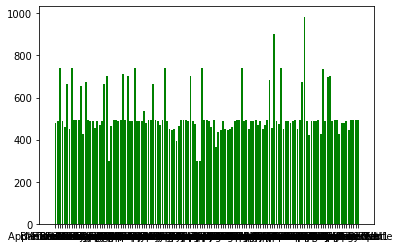

In [24]:
plt.bar(list(train_image_count.keys()), train_image_count.values(), color='g')
plt.show()

As we can see some class of images have more training data but mostly it is even.Because of this our model may be better at predicting these certain classes than the others

Now let us load the dataset and convert them into pytorch Tensors. We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [25]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [26]:
dataset = ImageFolder(data_dir+'/Training', transform=ToTensor())

Let us take a look at a sample element from the dataset

In [27]:
img, label = dataset[0]
print(img.shape, label)
img,dataset.classes[label]

torch.Size([3, 100, 100]) 0


(tensor([[[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

The tensor is of shape 3x100x100 which means that the images are colored(has 3 channels) and are of resolution 100x100

Let us take a look at some of the images from the dataset using matplotlib.First we can define a helper function to help
us view images

In [28]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Apple Braeburn (0)


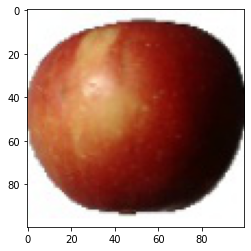

In [29]:
show_example(*dataset[0])

Label:  Physalis (97)


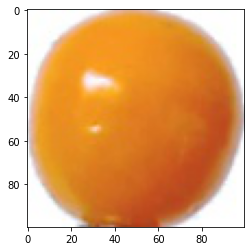

In [30]:
show_example(*dataset[50000])

As we can observe the images are pretty clear and we can easily identify the fruit by looking at the images

# Seperating dataset into training and validation sets
Before moving further,let us split our dataset into training and validation dataset.Creating a proper validation set is very important to measure the performance of our model

We use a fixed seed value to make sure we get the same validation set every time we create the model.This helps in
evaluating different model architectures against the same validation set

In [31]:
random_seed = 50
torch.manual_seed(random_seed);
len(dataset)

67692

In [32]:
val_percent = 0.05 #we take 5% data for validation at first
val_size = int(val_percent*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(64308, 3384)

The jovian library can be used to store our python notebooks in an easy and organized manner at <a href="https://jovian.ml/">jovian.ml</a><br>
The jovian library also provides a simple API for recording important parameters related to the dataset, model training, results etc. for easy reference and comparison between multiple experiments. Let's save out work to jovian and also record dataset_name, val_percent and rand_seed using jovian.log_dataset.

In [33]:
!pip install jovian --upgrade -q

In [34]:
import jovian

<IPython.core.display.Javascript object>

In [35]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
API KEY: ········


[jovian] Error: The current API key is invalid or expired.


[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········


ApiError: The API key provided is invalid or expired.

You can find your API key at your jovian.ml profile

In [ ]:
jovian.log_dataset(dataset_name='fruits-360', val_percent=val_percent, random_seed=random_seed)

Let us now create dataloaders for our training and validation datasets

In [36]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [37]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Now let us take a look at a batch of images from the training loader

In [38]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

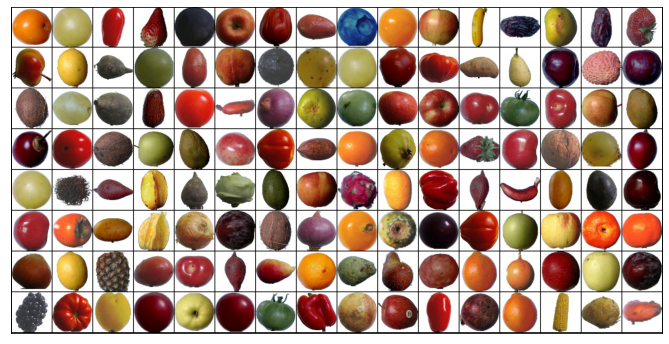

In [39]:
show_batch(train_dl)

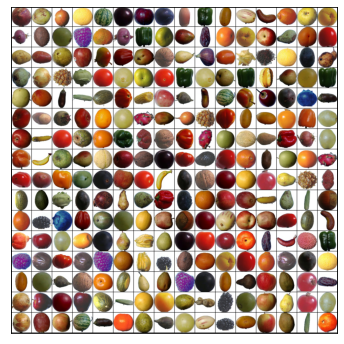

In [40]:
#look at valdation loader
show_batch(val_dl)

In [41]:
for images,_ in train_dl:
    print(images.shape)
    break

torch.Size([128, 3, 100, 100])


# Defining the model

We wiil create a **CNN** based model to tackle this classification problem as CNNs usually work great for image datasets

In [42]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [43]:
class Fruits360CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 50 x 50

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 25 x 25

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),#output :256*25*25
            nn.MaxPool2d(5, 5), # output: 256 x 5 x 5

            nn.Flatten(), 
            nn.Linear(256*5*5, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 131))
            
        
    def forward(self, xb):
        return self.network(xb)

In [44]:
model = Fruits360CnnModel()
model

Fruits360CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6400, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fe

Let's verify that the model produces the expected output on a batch of training data. The 131 outputs for each image can be interpreted as probabilities for the 131 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image. 

In [45]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 100, 100])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


out.shape: torch.Size([128, 131])
out[0]: tensor([ 0.0503,  0.0461,  0.0075, -0.0057,  0.0266,  0.0371,  0.0169,  0.0003,
        -0.0115, -0.0032, -0.0255, -0.0362, -0.0301, -0.0125,  0.0066,  0.0194,
        -0.0017, -0.0098,  0.0089,  0.0296,  0.0151, -0.0329, -0.0395,  0.0300,
        -0.0068,  0.0034, -0.0204,  0.0450,  0.0224, -0.0447,  0.0233,  0.0087,
         0.0110,  0.0349,  0.0435,  0.0272,  0.0291, -0.0263,  0.0304, -0.0025,
         0.0177,  0.0238,  0.0443,  0.0277, -0.0123,  0.0243, -0.0332,  0.0315,
        -0.0099,  0.0179, -0.0118,  0.0321,  0.0257, -0.0374,  0.0315, -0.0265,
         0.0257, -0.0022,  0.0318,  0.0488,  0.0257, -0.0146,  0.0431, -0.0259,
        -0.0107, -0.0033, -0.0333,  0.0223,  0.0371, -0.0036, -0.0260, -0.0291,
        -0.0375, -0.0094, -0.0543,  0.0367, -0.0339,  0.0277,  0.0379,  0.0113,
         0.0546, -0.0200, -0.0276,  0.0380, -0.0105,  0.0349, -0.0223,  0.0193,
        -0.0062, -0.0121, -0.0337, -0.0361, -0.0217, -0.0081,  0.0507, -0.0310

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [46]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [47]:
device = get_default_device()
device

device(type='cpu')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available), and use to_device to move our model to the GPU (if available).

In [48]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Fruits360CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6400, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fe

# Training the model
Now let us define a general fir function to train our model and also a function to evaluate our model 

In [49]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [50]:
model = to_device(Fruits360CnnModel(), device)

In [51]:
evaluate(model, val_dl)

{'val_loss': 4.875301361083984, 'val_acc': 0.0078125}

The initial accuracy is around 1%, which is what one might expect from a randomly intialized model (since it has a 1 in 131 chance of getting a label right by guessing randomly).

We'll use the following hyperparmeters (learning rate, no. of epochs, batch_size etc.) to train our model.

In [52]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001

It's important to record the hyperparameters of every experiment you do, to replicate it later and compare it against other experiments. We can record them using jovian.log_hyperparams.

In [67]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


Let us begin training by training the model for the first 3 epochs

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Just as we have recorded the hyperparameters, we can also record the final metrics achieved by the model using jovian.log_metrics for reference, analysis and comparison.

In [69]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


We can also plot the valdation set accuracies to study how the model improves over time.

In [70]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

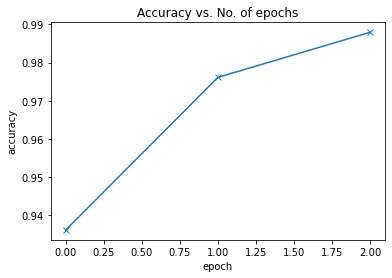

In [71]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend

In [72]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

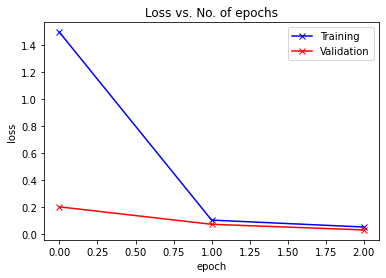

In [73]:
plot_losses(history)

Before continuing, let us save our work to the cloud using jovian.commit.

In [74]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/josudominic007/fruits-360-cnn


<IPython.core.display.Javascript object>

# Testing images from Test data set

### Testing individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset. We begin by creating a test dataset using the ImageFolder class.

In [ ]:
test_dataset = ImageFolder(data_dir+'/Test', transform=ToTensor())

Let's define a helper function predict_image, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[6157]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set, and record using jovian. We expect these values to be similar to those for the validation set. If not, we might need a better validation set that has similar data and distribution as the test set

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

As we can see we got only 91% accuracy on the test data while we got 98% on the validation data.This might be due to the validation set not having a sufficient distribution of images.We should be able to improve the accuracy on the test data if we increase the size of the validation set and train for a few more epochs

In [81]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


# Saving and Loading the Model
Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [82]:
torch.save(model.state_dict(), 'fruits360-cnn.pth')

The .state_dict method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model. To load the model weights, we can redefine the model with the same structure, and use the .load_state_dict method.

In [83]:
model2 = to_device(Fruits360CnnModel(), device)

In [84]:
model2.load_state_dict(torch.load('fruits360-cnn.pth'))

<All keys matched successfully>

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before

In [85]:
evaluate(model2, test_loader)

{'val_loss': 0.4599483013153076, 'val_acc': 0.9118679761886597}

Now lets make one final commit to jovian

In [86]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/josudominic007/fruits-360-cnn


<IPython.core.display.Javascript object>